In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
FERD_ROOT    = "/content/drive/MyDrive/FERD"
DATASET_NAME = "FERD"

In [13]:
import os
from glob import glob
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

TARGET_CLASSES = ["happy", "neutral", "sad"]
CLASS_TO_ID = {c: i for i, c in enumerate(TARGET_CLASSES)}
ID_TO_CLASS = {i: c for c, i in CLASS_TO_ID.items()}

class EmotionFolderDataset(Dataset):
    """
    ساختار فرضی:
      root/
        train/ یا test/ یا val/
          happy/*.jpg
          neutral/*.jpg
          sad/*.jpg
    """
    def __init__(self, root_dir, split="train", transform=None):
        self.transform = transform
        self.samples = []

        split_dir = os.path.join(root_dir, split)
        for cls_name in TARGET_CLASSES:
            cls_dir = os.path.join(split_dir, cls_name)
            files = glob(os.path.join(cls_dir, "*.*"))
            label = CLASS_TO_ID[cls_name]
            for f in files:
                self.samples.append((f, label))

        print(f"{root_dir} / {split} : {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [10]:
IMG_SIZE   = 224
BATCH_SIZE = 64

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

if DATASET_NAME == "FERD":
    # اگر Ferd هم همین ساختار را دارد، فقط root عوض می‌شود
    train_ds = EmotionFolderDataset(FERD_ROOT, split="train", transform=train_transform)
    val_ds   = EmotionFolderDataset(FERD_ROOT, split="test",  transform=val_transform)

else:
    raise ValueError("Unknown DATASET_NAME")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


/content/drive/MyDrive/FERD / train : 17083 samples.
/content/drive/MyDrive/FERD / test : 4180 samples.


In [14]:
!pip install timm scikit-learn onnx onnxruntime matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import prune
from torch.utils.data import DataLoader

import timm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)


In [16]:
NUM_CLASSES = 3   # happy, neutral, sad
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

class EmotionTransformer(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # مدل سبک ViT
        self.backbone = timm.create_model("vit_tiny_patch16_224", pretrained=True)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = EmotionTransformer(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds  = []
    all_probs  = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        probs = F.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        running_loss += loss.item() * imgs.size(0)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = np.concatenate(all_labels)
    all_preds  = np.concatenate(all_preds)
    all_probs  = np.concatenate(all_probs)

    return epoch_loss, epoch_acc, all_labels, all_preds, all_probs


In [18]:
NUM_EPOCHS = 20

best_val_acc = 0.0
best_state_dict = None
best_eval_outputs = None  # برای ذخیره‌ی y_true, y_pred, y_prob

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, y_true, y_pred, y_prob = evaluate(model, val_loader, criterion, DEVICE)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict().copy()
        best_eval_outputs = (y_true, y_pred, y_prob)

print("Best val acc:", best_val_acc)

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    y_true, y_pred, y_prob = best_eval_outputs


Epoch [1/20] Train Loss: 0.8170, Train Acc: 0.6176 | Val Loss: 0.6110, Val Acc: 0.7227
Epoch [2/20] Train Loss: 0.5947, Train Acc: 0.7390 | Val Loss: 0.5784, Val Acc: 0.7498
Epoch [3/20] Train Loss: 0.5327, Train Acc: 0.7676 | Val Loss: 0.6016, Val Acc: 0.7383
Epoch [4/20] Train Loss: 0.4997, Train Acc: 0.7849 | Val Loss: 0.5203, Val Acc: 0.7761
Epoch [5/20] Train Loss: 0.4674, Train Acc: 0.8020 | Val Loss: 0.5998, Val Acc: 0.7392
Epoch [6/20] Train Loss: 0.4262, Train Acc: 0.8203 | Val Loss: 0.5548, Val Acc: 0.7737
Epoch [7/20] Train Loss: 0.3991, Train Acc: 0.8349 | Val Loss: 0.5651, Val Acc: 0.7770
Epoch [8/20] Train Loss: 0.3705, Train Acc: 0.8468 | Val Loss: 0.5558, Val Acc: 0.7744
Epoch [9/20] Train Loss: 0.3440, Train Acc: 0.8586 | Val Loss: 0.5669, Val Acc: 0.7785
Epoch [10/20] Train Loss: 0.3173, Train Acc: 0.8704 | Val Loss: 0.5504, Val Acc: 0.7833
Epoch [11/20] Train Loss: 0.2929, Train Acc: 0.8858 | Val Loss: 0.6053, Val Acc: 0.7816
Epoch [12/20] Train Loss: 0.2745, Train A

In [19]:
def apply_pruning(model, amount=0.3):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")  # mask → وزن واقعی

apply_pruning(model, amount=0.3)

# بعد از pruning یک ارزیابی دوباره:
_, val_acc, y_true, y_pred, y_prob = evaluate(model, val_loader, criterion, DEVICE)
print("Validation accuracy after pruning:", val_acc)


Validation accuracy after pruning: 0.759090909090909


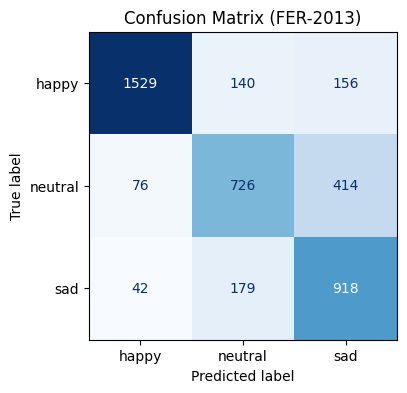

Confusion matrix (rows: true, cols: pred):
[[1529  140  156]
 [  76  726  414]
 [  42  179  918]]


In [20]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[ID_TO_CLASS[i] for i in [0,1,2]]
)

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (FER-2013)")
plt.show()

print("Confusion matrix (rows: true, cols: pred):")
print(cm)


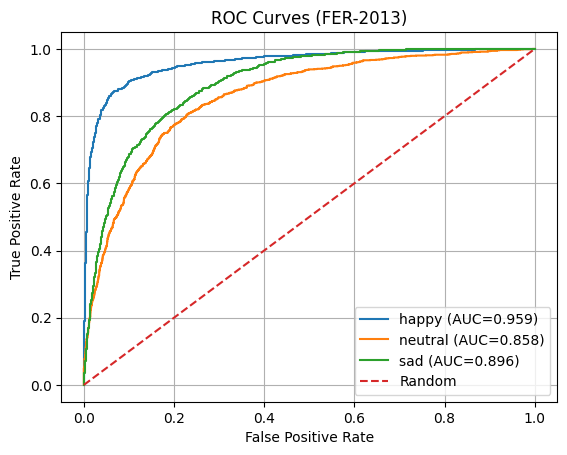

Per-class AUC:
happy: 0.9587
neutral: 0.8578
sad: 0.8958
Macro AUC (RAUC): 0.904107068631317


In [21]:
# AUC برای هر کلاس (One-vs-Rest)
auc_per_class = {}
for c in range(NUM_CLASSES):
    y_true_bin = (y_true == c).astype(int)
    fpr, tpr, _ = roc_curve(y_true_bin, y_prob[:, c])
    auc_value = roc_auc_score(y_true_bin, y_prob[:, c])
    auc_per_class[ID_TO_CLASS[c]] = auc_value

    plt.plot(fpr, tpr, label=f"{ID_TO_CLASS[c]} (AUC={auc_value:.3f})")

plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (FER-2013)")
plt.legend()
plt.grid(True)
plt.show()

print("Per-class AUC:")
for cls_name, auc_value in auc_per_class.items():
    print(f"{cls_name}: {auc_value:.4f}")

# RAUC = macro-average AUC
macro_auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
print("Macro AUC (RAUC):", macro_auc)


In [23]:
IMG_SIZE = 224  # اگر قبلاً جای دیگه تعریف کردی، هماهنگ باشه
DATASET_NAME = "FERD"  # بعداً برای Ferd عوض می‌کنی

onnx_filename = f"emotion_transformer_{DATASET_NAME}.onnx"

model_cpu = model.to("cpu")
model_cpu.eval()

dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

torch.onnx.export(
    model_cpu,
    dummy_input,
    onnx_filename,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=14,
    export_params=True,
    do_constant_folding=True,
)


print("Saved ONNX model to:", onnx_filename)


/tmp/ipython-input-3664211169.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Saved ONNX model to: emotion_transformer_FERD.onnx
